In [2]:
#Подключаем библиотеки
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from google.colab import files
from tensorflow.keras import utils
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/datasets/voice/genres.zip', 'r')
z.extractall()
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [5]:
#Функция параметризации аудир
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
  rmse = np.mean(librosa.feature.rmse(y=y))
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
  zcr = np.mean(librosa.feature.zero_crossing_rate(y))
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [6]:
#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] 
  for filename in os.listdir(f'./genres/{g}'):
    songname = f'./genres/{g}/{filename}'
    y, sr = librosa.load(songname, mono=True, duration=30)
    out = get_features(y, sr)

    X_train.append(out)
    Y_train.append(utils.to_categorical(i, len(genres)))

  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 95c
Жанр classical готов -> 90c
Жанр country готов -> 92c
Жанр disco готов -> 93c
Жанр hiphop готов -> 92c
Жанр jazz готов -> 89c
Жанр metal готов -> 89c
Жанр pop готов -> 86c
Жанр reggae готов -> 86c
Жанр rock готов -> 85c


In [11]:
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [12]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()
columns = ['dense', 'neuron', 'drop', 'BN', 'activation', 'batch_size', 'acc', 'val_acc']

In [13]:
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [14]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [15]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [16]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1, shuffle=True)

In [17]:
#Выводим размеры обучающей и проверочной выборки для проверки

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(900, 26)
(100, 26)
(900,)
(100,)


In [22]:
data = []

Epoch 1/150
45/45 [==============================] - 0s 6ms/step - loss: 2.1541 - accuracy: 0.2322 - val_loss: 2.0058 - val_accuracy: 0.3200
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.8471 - accuracy: 0.3589 - val_loss: 1.8305 - val_accuracy: 0.3200
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.6913 - accuracy: 0.3833 - val_loss: 1.7187 - val_accuracy: 0.3500
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5820 - accuracy: 0.4333 - val_loss: 1.6380 - val_accuracy: 0.4200
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4969 - accuracy: 0.4822 - val_loss: 1.5799 - val_accuracy: 0.4100
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4297 - accuracy: 0.5178 - val_loss: 1.5286 - val_accuracy: 0.4200
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3745 - accuracy: 0.5344 - val_loss: 1.4914 - val_accuracy: 0.4400
Epoch 8/150
4

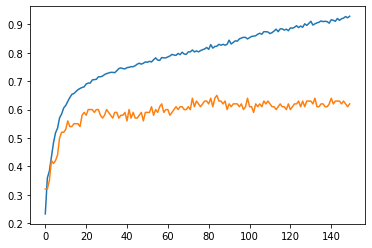

In [23]:
indexes = range(0,26)

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=150,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

data +=[[4, '256-128-64-32', '-', '-', 'elu', 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
45/45 [==============================] - 0s 4ms/step - loss: 2.6803 - accuracy: 0.0711 - val_loss: 2.6980 - val_accuracy: 0.0600
Epoch 2/150
45/45 [==============================] - 0s 2ms/step - loss: 2.6163 - accuracy: 0.0811 - val_loss: 2.6488 - val_accuracy: 0.0600
Epoch 3/150
45/45 [==============================] - 0s 2ms/step - loss: 2.5594 - accuracy: 0.0856 - val_loss: 2.6028 - val_accuracy: 0.0700
Epoch 4/150
45/45 [==============================] - 0s 2ms/step - loss: 2.5062 - accuracy: 0.0978 - val_loss: 2.5598 - val_accuracy: 0.0900
Epoch 5/150
45/45 [==============================] - 0s 2ms/step - loss: 2.4569 - accuracy: 0.1189 - val_loss: 2.5197 - val_accuracy: 0.1100
Epoch 6/150
45/45 [==============================] - 0s 2ms/step - loss: 2.4102 - accuracy: 0.1344 - val_loss: 2.4817 - val_accuracy: 0.1100
Epoch 7/150
45/45 [==============================] - 0s 2ms/step - loss: 2.3668 - accuracy: 0.1622 - val_loss: 2.4462 - val_accuracy: 0.1100
Epoch 8/150
4

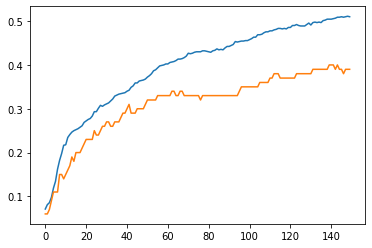

In [24]:
#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(10, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=150,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

data +=[[1, '10', '-', '-', 'elu', 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
45/45 [==============================] - 0s 7ms/step - loss: 1.6641 - accuracy: 0.4011 - val_loss: 1.5581 - val_accuracy: 0.4500
Epoch 2/150
45/45 [==============================] - 0s 4ms/step - loss: 1.3391 - accuracy: 0.5278 - val_loss: 1.4088 - val_accuracy: 0.5400
Epoch 3/150
45/45 [==============================] - 0s 4ms/step - loss: 1.1964 - accuracy: 0.6133 - val_loss: 1.3026 - val_accuracy: 0.5400
Epoch 4/150
45/45 [==============================] - 0s 4ms/step - loss: 1.0943 - accuracy: 0.6478 - val_loss: 1.2693 - val_accuracy: 0.5500
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.0251 - accuracy: 0.6567 - val_loss: 1.2238 - val_accuracy: 0.5500
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 0.9663 - accuracy: 0.6711 - val_loss: 1.1749 - val_accuracy: 0.5700
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 0.9286 - accuracy: 0.6789 - val_loss: 1.1750 - val_accuracy: 0.5800
Epoch 8/150
4

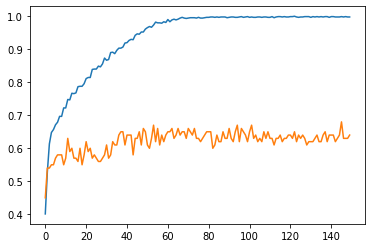

In [25]:
#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(1024, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(128, activation='elu'))
model.add(Dense(128, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=150,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

data +=[[6, '1024-512-256-128-128-128', '-', '-', 'elu', 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
45/45 [==============================] - 0s 5ms/step - loss: 2.1224 - accuracy: 0.2433 - val_loss: 1.9768 - val_accuracy: 0.2600
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.8401 - accuracy: 0.3433 - val_loss: 1.8096 - val_accuracy: 0.3000
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.7028 - accuracy: 0.4111 - val_loss: 1.7125 - val_accuracy: 0.3500
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5950 - accuracy: 0.4433 - val_loss: 1.6218 - val_accuracy: 0.4100
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5188 - accuracy: 0.4544 - val_loss: 1.5676 - val_accuracy: 0.4200
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4600 - accuracy: 0.4878 - val_loss: 1.5212 - val_accuracy: 0.4400
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3959 - accuracy: 0.5022 - val_loss: 1.4803 - val_accuracy: 0.4800
Epoch 8/150
4

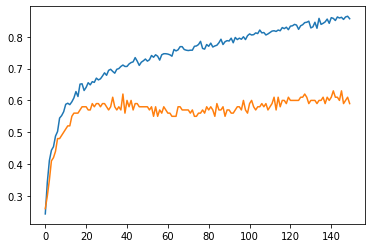

In [26]:
#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=150,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

data +=[[4, '256-128-64-32', '+', '-', 'elu', 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
45/45 [==============================] - 0s 6ms/step - loss: 2.1418 - accuracy: 0.2456 - val_loss: 1.9991 - val_accuracy: 0.2700
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.6846 - accuracy: 0.4278 - val_loss: 1.8174 - val_accuracy: 0.3400
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5371 - accuracy: 0.4722 - val_loss: 1.7062 - val_accuracy: 0.3600
Epoch 4/150
45/45 [==============================] - 0s 4ms/step - loss: 1.4110 - accuracy: 0.5422 - val_loss: 1.5863 - val_accuracy: 0.4400
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3199 - accuracy: 0.5711 - val_loss: 1.5169 - val_accuracy: 0.4700
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.2473 - accuracy: 0.5878 - val_loss: 1.4589 - val_accuracy: 0.4800
Epoch 7/150
45/45 [==============================] - 0s 4ms/step - loss: 1.1815 - accuracy: 0.6433 - val_loss: 1.3923 - val_accuracy: 0.5100
Epoch 8/150
4

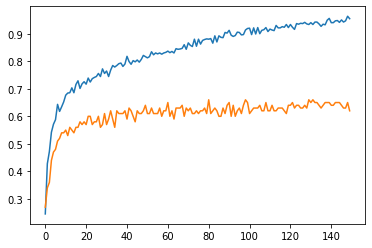

In [27]:
#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(BatchNormalization())
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=150,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

data +=[[4, '256-128-64-32', '-', '+', 'elu', 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/150
45/45 [==============================] - 0s 6ms/step - loss: 2.2407 - accuracy: 0.1600 - val_loss: 2.1990 - val_accuracy: 0.1700
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 2.1279 - accuracy: 0.2978 - val_loss: 2.1085 - val_accuracy: 0.2700
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 2.0172 - accuracy: 0.3700 - val_loss: 2.0198 - val_accuracy: 0.2800
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.9057 - accuracy: 0.4078 - val_loss: 1.9358 - val_accuracy: 0.3300
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.8046 - accuracy: 0.4256 - val_loss: 1.8638 - val_accuracy: 0.3200
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.7161 - accuracy: 0.4478 - val_loss: 1.8032 - val_accuracy: 0.3400
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.6383 - accuracy: 0.4544 - val_loss: 1.7491 - val_accuracy: 0.3600
Epoch 8/150
4

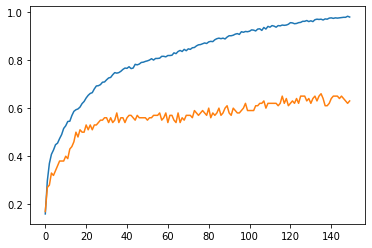

Epoch 1/150
45/45 [==============================] - 0s 6ms/step - loss: 2.1038 - accuracy: 0.2756 - val_loss: 1.8295 - val_accuracy: 0.3600
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5977 - accuracy: 0.4600 - val_loss: 1.5990 - val_accuracy: 0.4200
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4332 - accuracy: 0.5133 - val_loss: 1.4899 - val_accuracy: 0.4600
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3328 - accuracy: 0.5478 - val_loss: 1.4056 - val_accuracy: 0.4900
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.2564 - accuracy: 0.5800 - val_loss: 1.3808 - val_accuracy: 0.4900
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.2022 - accuracy: 0.5978 - val_loss: 1.3184 - val_accuracy: 0.5200
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.1545 - accuracy: 0.6089 - val_loss: 1.3130 - val_accuracy: 0.5000
Epoch 8/150
4

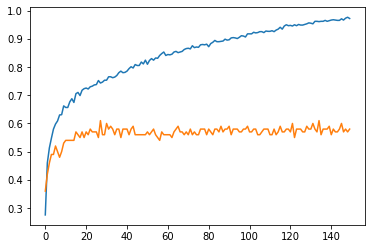

Epoch 1/150
45/45 [==============================] - 0s 6ms/step - loss: 2.0441 - accuracy: 0.2633 - val_loss: 1.9649 - val_accuracy: 0.2300
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.6783 - accuracy: 0.3944 - val_loss: 1.7379 - val_accuracy: 0.3600
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5230 - accuracy: 0.4522 - val_loss: 1.6199 - val_accuracy: 0.3900
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4173 - accuracy: 0.4967 - val_loss: 1.5390 - val_accuracy: 0.4400
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3456 - accuracy: 0.5422 - val_loss: 1.4598 - val_accuracy: 0.5100
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.2857 - accuracy: 0.5633 - val_loss: 1.4093 - val_accuracy: 0.5300
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.2437 - accuracy: 0.5856 - val_loss: 1.3878 - val_accuracy: 0.5200
Epoch 8/150
4

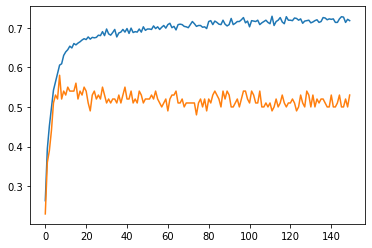

In [28]:
activ = ['relu', 'selu', 'linear']
for i in activ:
        
    #Создаём полносвязанную сеть 
    model = Sequential()
    model.add(Dense(256, activation=i, input_shape=(len(indexes),)))
    model.add(Dense(128, activation=i))
    model.add(Dense(64, activation=i))
    model.add(Dense(32, activation=i))
    #В конце количество нейронов равно количеству классов и softmax
    model.add(Dense(len(genres), activation='softmax'))

    #Компилируем сеть
    model.compile(optimizer=RMSprop(lr=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    #Обучаем
    history = model.fit(X_train[:, indexes],
                        y_train,
                        epochs=150,
                        batch_size=20,
                        validation_data=(X_test[:, indexes], y_test))

    data +=[[4, '256-128-64-32', '-', '-', i, 20, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
    #Выводим график точности распознавания на обучающей и проверочной выборках
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

Epoch 1/150
45/45 [==============================] - 0s 5ms/step - loss: 2.0493 - accuracy: 0.2833 - val_loss: 1.8684 - val_accuracy: 0.3200
Epoch 2/150
45/45 [==============================] - 0s 3ms/step - loss: 1.7254 - accuracy: 0.4111 - val_loss: 1.7078 - val_accuracy: 0.3600
Epoch 3/150
45/45 [==============================] - 0s 3ms/step - loss: 1.5803 - accuracy: 0.4378 - val_loss: 1.5997 - val_accuracy: 0.3800
Epoch 4/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4843 - accuracy: 0.4633 - val_loss: 1.5396 - val_accuracy: 0.4200
Epoch 5/150
45/45 [==============================] - 0s 3ms/step - loss: 1.4157 - accuracy: 0.4833 - val_loss: 1.4873 - val_accuracy: 0.4600
Epoch 6/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3576 - accuracy: 0.5244 - val_loss: 1.4514 - val_accuracy: 0.5000
Epoch 7/150
45/45 [==============================] - 0s 3ms/step - loss: 1.3079 - accuracy: 0.5578 - val_loss: 1.4148 - val_accuracy: 0.5100
Epoch 8/150
4

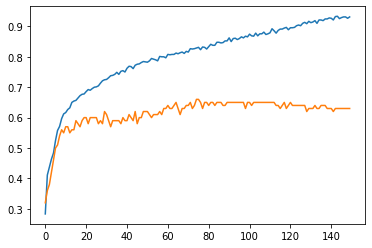

Epoch 1/150
15/15 [==============================] - 0s 12ms/step - loss: 2.1653 - accuracy: 0.2389 - val_loss: 2.0219 - val_accuracy: 0.3300
Epoch 2/150
15/15 [==============================] - 0s 4ms/step - loss: 1.9437 - accuracy: 0.3533 - val_loss: 1.9063 - val_accuracy: 0.3800
Epoch 3/150
15/15 [==============================] - 0s 4ms/step - loss: 1.8239 - accuracy: 0.3833 - val_loss: 1.8237 - val_accuracy: 0.3800
Epoch 4/150
15/15 [==============================] - 0s 4ms/step - loss: 1.7371 - accuracy: 0.4067 - val_loss: 1.7632 - val_accuracy: 0.3700
Epoch 5/150
15/15 [==============================] - 0s 4ms/step - loss: 1.6718 - accuracy: 0.4089 - val_loss: 1.7104 - val_accuracy: 0.3600
Epoch 6/150
15/15 [==============================] - 0s 4ms/step - loss: 1.6162 - accuracy: 0.4389 - val_loss: 1.6639 - val_accuracy: 0.3900
Epoch 7/150
15/15 [==============================] - 0s 4ms/step - loss: 1.5704 - accuracy: 0.4544 - val_loss: 1.6329 - val_accuracy: 0.3800
Epoch 8/150


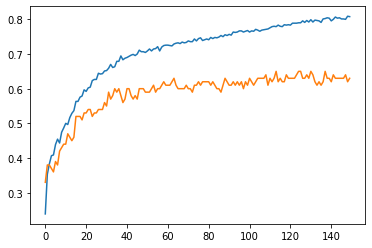

Epoch 1/150
4/4 [==============================] - 0s 34ms/step - loss: 2.2727 - accuracy: 0.2122 - val_loss: 2.2070 - val_accuracy: 0.2500
Epoch 2/150
4/4 [==============================] - 0s 8ms/step - loss: 2.1311 - accuracy: 0.2567 - val_loss: 2.1215 - val_accuracy: 0.2900
Epoch 3/150
4/4 [==============================] - 0s 8ms/step - loss: 2.0476 - accuracy: 0.2767 - val_loss: 2.0581 - val_accuracy: 0.2900
Epoch 4/150
4/4 [==============================] - 0s 7ms/step - loss: 1.9828 - accuracy: 0.2889 - val_loss: 2.0026 - val_accuracy: 0.2800
Epoch 5/150
4/4 [==============================] - 0s 7ms/step - loss: 1.9274 - accuracy: 0.3111 - val_loss: 1.9565 - val_accuracy: 0.3000
Epoch 6/150
4/4 [==============================] - 0s 7ms/step - loss: 1.8793 - accuracy: 0.3244 - val_loss: 1.9165 - val_accuracy: 0.3200
Epoch 7/150
4/4 [==============================] - 0s 7ms/step - loss: 1.8383 - accuracy: 0.3456 - val_loss: 1.8791 - val_accuracy: 0.3300
Epoch 8/150
4/4 [=========

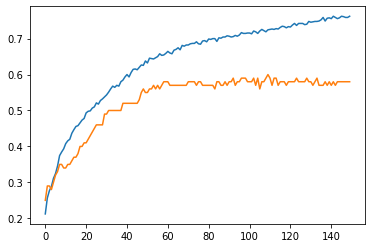

Epoch 1/150
1/1 [==============================] - 0s 128ms/step - loss: 2.3993 - accuracy: 0.1189 - val_loss: 2.2988 - val_accuracy: 0.1500
Epoch 2/150
1/1 [==============================] - 0s 18ms/step - loss: 2.3075 - accuracy: 0.1656 - val_loss: 2.2491 - val_accuracy: 0.1700
Epoch 3/150
1/1 [==============================] - 0s 18ms/step - loss: 2.2478 - accuracy: 0.1922 - val_loss: 2.2111 - val_accuracy: 0.2000
Epoch 4/150
1/1 [==============================] - 0s 18ms/step - loss: 2.2017 - accuracy: 0.2089 - val_loss: 2.1797 - val_accuracy: 0.2100
Epoch 5/150
1/1 [==============================] - 0s 17ms/step - loss: 2.1635 - accuracy: 0.2144 - val_loss: 2.1528 - val_accuracy: 0.2200
Epoch 6/150
1/1 [==============================] - 0s 19ms/step - loss: 2.1305 - accuracy: 0.2189 - val_loss: 2.1292 - val_accuracy: 0.2300
Epoch 7/150
1/1 [==============================] - 0s 18ms/step - loss: 2.1013 - accuracy: 0.2256 - val_loss: 2.1081 - val_accuracy: 0.2400
Epoch 8/150
1/1 [==

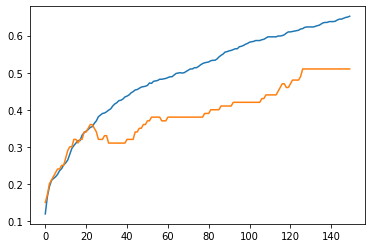

In [29]:
batch_s = [20, 64, 256, 1024]
for i in batch_s:
        
    #Создаём полносвязанную сеть 
    model = Sequential()
    model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
    model.add(Dense(128, activation='elu'))
    model.add(Dense(64, activation='elu'))
    model.add(Dense(32, activation='elu'))
    #В конце количество нейронов равно количеству классов и softmax
    model.add(Dense(len(genres), activation='softmax'))

    #Компилируем сеть
    model.compile(optimizer=RMSprop(lr=1e-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    #Обучаем
    history = model.fit(X_train[:, indexes],
                        y_train,
                        epochs=150,
                        batch_size=i,
                        validation_data=(X_test[:, indexes], y_test))

    data +=[[4, '256-128-64-32', '-', '-', 'elu', i, history.history["accuracy"][-1], history.history["val_accuracy"][-1]]]
    #Выводим график точности распознавания на обучающей и проверочной выборках
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.show()

In [30]:
import pandas as pd
df = pd.DataFrame(data, columns= columns)
df

,dense,neuron,drop,BN,activation,batch_size,acc,val_acc
0,4,256-128-64-32,-,-,elu,20,0.928889,0.62
1,1,10,-,-,elu,20,0.510000,0.39
2,6,1024-512-256-128-128-128,-,-,elu,20,0.997778,0.64
3,4,256-128-64-32,+,-,elu,20,0.856667,0.59
4,4,256-128-64-32,-,+,elu,20,0.954444,0.62
5,4,256-128-64-32,-,-,relu,20,0.978889,0.63
6,4,256-128-64-32,-,-,selu,20,0.972222,0.58
7,4,256-128-64-32,-,-,linear,20,0.717778,0.53
8,4,256-128-64-32,-,-,elu,20,0.931111,0.63
9,4,256-128-64-32,-,-,elu,64,0.807778,0.63
